In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings
import dill as pickle

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

# Load unmitigated model

In [29]:
with open("./pretrained_models/RandomForest.pickle", "rb") as handle:
    rf0 = pickle.load(handle)

input_features = ['is_credit', 'same_country', 'merchant_Merchant B',
                  'merchant_Merchant C', 'merchant_Merchant D', 'merchant_Merchant E',
                  'card_scheme_MasterCard', 'card_scheme_Other', 'card_scheme_Visa',
                  'device_type_Linux', 'device_type_MacOS', 'device_type_Other',
                  'device_type_Windows', 'device_type_iOS', 'shopper_interaction_POS',
                  'is_night', 'is_weekend', 'diff_tx_time_in_hours',
                  'is_diff_previous_ip_country', 'card_nb_tx_1day_window',
                  'card_avg_amount_1day_window', 'card_nb_tx_7day_window',
                  'card_avg_amount_7day_window', 'card_nb_tx_30day_window',
                  'card_avg_amount_30day_window', 'email_address_nb_tx_1day_window',
                  'email_address_risk_1day_window', 'email_address_nb_tx_7day_window',
                  'email_address_risk_7day_window', 'email_address_nb_tx_30day_window',
                  'email_address_risk_30day_window', 'ip_address_nb_tx_1day_window',
                  'ip_address_risk_1day_window', 'ip_address_nb_tx_7day_window',
                  'ip_address_risk_7day_window', 'ip_address_nb_tx_30day_window',
                  'ip_address_risk_30day_window']

output_feature = "has_fraudulent_dispute"

sensitive_feature = "issuing_country"

In [30]:
df_features = pd.read_csv("../feature-engineering/final_features.csv")
df_features["tx_datetime"] = pd.to_datetime(df_features["tx_datetime"])
df_test = df_features[df_features["tx_datetime"] >= "2021-12-01"]
X_test = df_test[input_features]
y_test = df_test[output_feature]
y_pred = rf0.predict(X_test)
A_test = df_test[sensitive_feature]

# Fairness metrics

In [31]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

In [32]:
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

In [45]:
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test,
)

metricframe_unmitigated.by_group[metrics_to_report].to_dict()

# metricframe_unmitigated.difference()[metrics_to_report]
#
# metricframe_unmitigated.overall[metrics_to_report]

{'balanced_accuracy': {'BR': 0.9159675114731294,
  'GR': 0.9400460898007731,
  'IT': 0.9156486329261198,
  'NL': 0.9423401493021746,
  'ZW': 0.8898664569537411},
 'false_positive_rate': {'BR': 0.05358686257562662,
  'GR': 0.036574487065120426,
  'IT': 0.05759162303664921,
  'NL': 0.04608893216488153,
  'ZW': 0.03905903240124279},
 'false_negative_rate': {'BR': 0.11447811447811448,
  'GR': 0.08333333333333333,
  'IT': 0.1111111111111111,
  'NL': 0.06923076923076923,
  'ZW': 0.18120805369127516}}

In [34]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

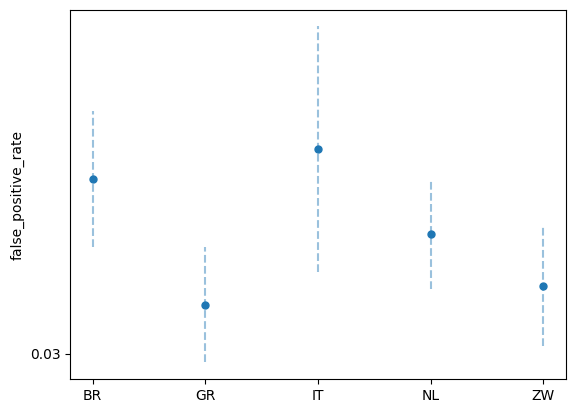

In [35]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_positive_rate", "false_positive_error"
)

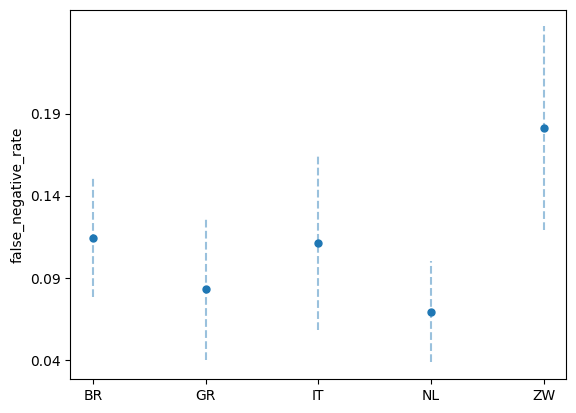

In [39]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_negative_rate", "false_negative_error"
)

array([[<AxesSubplot: title={'center': 'balanced_accuracy'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_positive_rate'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_negative_rate'}, xlabel='issuing_country'>]],
      dtype=object)

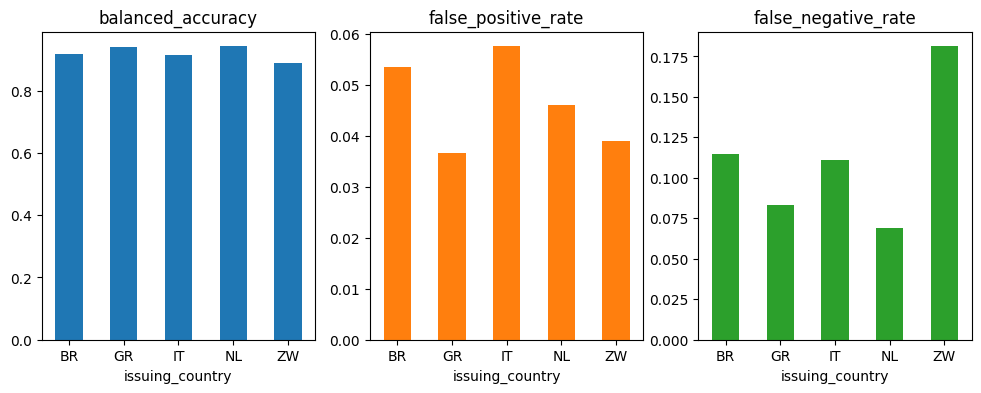

In [36]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

In [43]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, y_pred, sensitive_features=A_test
)
equalized_odds_unmitigated

0.11197728446050592